In [3]:
from IPython.display import Image
from oct2py import octave as oct
from os.path import join
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt

In [7]:
def get_matlab_data(directory, filename):
    """
    Imports the matlab scripts generated during execution of
        C codes, and returns an array with the data neccesary
        for analysis of performance
    """
    oct.eval(f"cd {directory};")
    oct.eval(f"{filename};")
    oct.eval(f"save -v7 {filename}.mat;")
    data = sio.loadmat(f"{join(directory, filename)}.mat")

    return data['data']

# Layering Matrix-Matrix Multiplication

## The dot product (inner product)

Given two vectors `x` and `y`

$$
x = \begin{bmatrix}
\chi_0 \\ \chi_1 \\ \vdots \\ \chi_{n-1}
\end{bmatrix}
\;\;\;\;\;\;
y = \begin{bmatrix}
\psi_0 \\ \psi_1 \\ \vdots \\ \psi_{n-1}
\end{bmatrix}
$$

the dot product between them is computed as

$
x^T y = \chi_0 \psi_0 + \chi_1 \psi_1 + \dots + \chi_{n-1} \psi_{n-1}
= \sum_{i = 0}^{n-1} \chi_i \psi_i
$

The notation $x^T y$ corresponds to the fact that the dot product is
equivalent to a matrix matrix multiplication of a matrix with dimensions
`1 x n` and a second matrix of dimensions `n x 1`.

$
x^T y = \begin{bmatrix}
\chi_0 & \chi_1 & \dots & \chi_{n-1}
\end{bmatrix}
\begin{bmatrix}
\psi_0 \\ \psi_1 \\ \vdots \\ \psi_{n-1}
\end{bmatrix}
$

The pseudocode for computing the dot product would be
```python
dot_product = 0
for i in range(n):
    dot_product += x[i] * y[i]
```

Since we are reviewing the dot product in terms of **matrix - matrix**
multiplication, the pseudocode written above may not suffice our needs. Recall
that a given element $\gamma_{i, j}$ of `C`, can be obtained by computing the
dot product of a row $a_{i}^{\sim T}$ of `A` and a column $b_{j}$ of `B`. Remember
also, that we are storing our matrices arrays with *column major order*, which
means that the entries of $a_{i}^{\sim T}$ are not stored contiguously in memory,
so one need to remember the concept of **leading dimension**, in this case for
matrix `A`. The leading dimension can be seen as the offset needed to *advance*
one column and land in the exact same row as before.

Now, an algorithm to compute the dot product of two vectors in the context of
**matrix - matrix** multiplication needs to take into account the offsets
(increments) needed in order to get to the next entrie of the vector for each
of the two arrays `x` and `y`. A *C* code snippet is presented below

```c
#define chi(i) x[i * incx]
#define psi(i) y[i * incy]

/*
 * n -> size of the two vectors
 * x -> address of first element of x
 * incx -> increment in the x array in order no get the next element
 * y -> address of first element of y
 * incy -> increment in the y array in order no get the next element
 * gamma -> address of the element where the result is stored
 */
void Dots( int n, double *x, int incx, double *y, int incy, double *gamma )
{
    for(int i = 0; i < n; i++)
    {
        /* staff solution */
        *gamma += chi(i) * psi(i);

        /* own solution, without macros */
        *gamma += x[i * incx] * y[i * incy];
        /* or */
        *gamma += *(x + i * incx) * *(y + i * incy);
    }
}
```

In the context of **matrix - matrix** multiplication, the value of `incx` will
be the the leading dimension of `A`, `ldA`, since the elements of the rows of
`A` are not stored contiguously in memory. On the other hand, the vector `y`
corresponds to a column of matrix `B` hence its elements are stored
contiguously, so the value of `incy` should be `1`.

## Matrix-vector multiplication via dot products
Matrix vector multiplication is expressed as

$
y := Ax + y
$

what the equation above states is that we begin with a vector `y`, which is
being updated as we start performing the **matrix - vector** multiplication
$Ax$.

The way that **matrix - vector** multiplication is taught is by performing dot
product operations between each row $a_i^{\sim T}$ of matrix `A` and the vector
`x`. If we expose the elements of the matrix and vectors we get

$$
y = \begin{bmatrix}
\psi_0 \\ \psi_1 \\ \vdots \\ \psi_{m - 1}
\end{bmatrix}
\;\;\;
A = \begin{bmatrix}
a_0^{\sim T} \\ -- \\ a_1{\sim T} \\ -- \\ \vdots \\ -- \\ a_{m-1}^{\sim T}
\end{bmatrix}
\;\;\;
x = \begin{bmatrix}
\chi_0 \\ \chi_1 \\ \vdots \\ \chi_{m-1}
\end{bmatrix}
$$

**Note the notation stablished, greek letters for entries of vectors,
lower-case roman letters for vector**

If we expose the arrays in terms of the equation stated above

$$
\begin{bmatrix}
\psi_0 \\ \psi_1 \\ \vdots \\ \psi_{m - 1}
\end{bmatrix}
\;\;:= \;\;
\begin{bmatrix}
a_0^{\sim T} \\ -- \\ a_1{\sim T} \\ -- \\ \vdots \\ a_{m - 1}^{\sim T}
\end{bmatrix}
\begin{bmatrix}
\chi_0 \\ \chi_1 \\ \vdots \\ \chi_{m - 1}
\end{bmatrix}
\; + \; 
\begin{bmatrix}
\psi_0 \\ \psi_1 \\ \vdots \\ \psi_{m - 1}
\end{bmatrix}
\;\; = \;\;
\begin{bmatrix}
a_0^{\sim T} x \\ -- \\ a_1^{\sim T} \\ -- \\ \vdots \\ --
    \\ a_{m - 1}^{\sim T}
\end{bmatrix}
\; + \;
\begin{bmatrix}
\psi_0 \\ \psi_1 \\ \vdots \\ \psi_{m - 1}
\end{bmatrix}
\;\; = \;\; 
\begin{bmatrix}
a_0^{\sim T} x + \chi_0 \\ -- \\ a_1^{\sim T} + \chi_1 \\ -- \\ \vdots \\ --
    \\ a_{m - 1}^{\sim T} + \chi_{m - 1}
\end{bmatrix}
$$

$$
= \begin{bmatrix}
\alpha_{0, 0} \chi_0 + \alpha_{0, 1} \chi_1 + \dots
    + \alpha_{0, n-1} \chi_{n-1} + \psi_0 \\
\alpha_{1, 0} \chi_0 + \alpha_{1, 1} \chi_1 + \dots
    + \alpha_{1, n-1} \chi_{n-1}  + \psi_1 \\
\vdots \\
\vdots \\
\alpha_{m-1, 0} \chi_{0} + \alpha_{m-1, 1} \chi_{1} + \dots
    + \alpha_{m-1, n-1} \chi_{n-1} + \psi_{n-1}
\end{bmatrix}
$$

With all of this in mind, we can now structure **matrix - vector**
multiplication in terms of `IJ` loops, a corresponding pseudocode is presented
```python
for i in range(m):
    for j in range(n):
        psi[i] += alpha[i, j] * chi[j]
```
from this we observe that the inner `J` loop is nothing more that the previous
explained algorithm for the *dot product*. In other words we can write our
pseudocode as
```python
def matrix_vector(m, n, A, x, y)
    """
    computes:
        y = Ax + y
    ...
    m -> number of rows of A
    n -> number of columns of `A`, number of entries in both `x` and `y`
    A -> address of first element of matrix `A`
    x -> address of first element of vector `x`
    y -> address of first element of vector `y`
    a_T[i] -> address of first entry of row vector `i` of matrix `A`
    psi[i] -> address of `i` element of vector `y`
    """
    for i in range(m):
        dot_product(n, a_T[i], x, psi[i])

def dot_product(n, x, y, gamma):
    """
    computes:
        gamma = xy + gamma
    ...
    n -> number of entries in vectors `x` and `y`
    x -> address of first element of vector `x`
    y -> address of first element of vector `y`
    gamma -> address of variable where the resulting dot product is stored
    """
    for j in range(n):
        gamma += x[j] * y[j]

```

### Homework 1.3.3.2
In directory Assignments/Week1/C complete the implementation of matrix-vector multiplication in terms of dot operations.

[Assignments/Week1/C/Gemv_I_Dots.c](../Gemv_I_Dots.c)

```c
#define alpha(i, j) A[(j) * ldA + i ]   // map alpha(i,j) to array A
#define chi(i)  x[(i) * incx ]         // map chi(i)  to array x
#define psi(i)  y[(i) * incy ]         // map psi(i)  to array y


void    Dots(int n, double *x, int incx, double *y, int incy, double *gamma);

void    MyGemv( int m, int n, double *A, int ldA,
           double *x, int incx, double *y, int incy )
{
  for (int i = 0; i < m; i++)
    Dots(n, A + i, ldA, x, incx, y + i * incy);
}
```
The file **Gemv_I_Dots.c** stands for:
* Gemv -> GEneral Matrix-Vector multiplication
* I -> iteration over the `i` variable (`m` dimension)
* Dots -> the operation performed on the body of the routine is a **Dot product**


## 1.3.4 The axpy operation
The `axpy` operation stands for **alpha times x plus y**, which means that
`alpha` is a scalar and `x` and `y` are vectors of size `n`, then
$$
x = \begin{bmatrix}
\chi_0 \\ \chi_1 \\ \vdots \\ \chi_{n - 1}
\end{bmatrix}
\;\;\;
y = \begin{bmatrix}
\psi_0 \\ \psi_1 \\ \vdots \\ \psi_{n - 1}
\end{bmatrix}
$$

Mathematically, the operation performed in `axpy` is
$$
y := \alpha x + y
$$
which, when the vectors' elements are exposed, becomes
$$
\begin{bmatrix}
\psi_0 \\ \psi_1 \\ \vdots \\ \psi_{n - 1}
\end{bmatrix}
\; = \;
\alpha \begin{bmatrix}
\chi_0 \\ \chi_1 \\ \vdots \\ \chi_{n - 1}
\end{bmatrix}
\; + \;
\begin{bmatrix}
\psi_0 \\ \psi_1 \\ \vdots \\ \psi_{n - 1}
\end{bmatrix}
\;\; = \;\;
\begin{bmatrix}
\alpha \chi_0 + \psi_0 \\ \alpha \chi_1 + \psi_1 \\ \vdots \\
    \alpha \chi_{n - 1} + \psi_{n - 1}
\end{bmatrix}
$$

A pseducode for an axpy operation goes as follows
```python
for i in range(m):
    psi[i] += alpha * chi[i]
```

### Homework 1.3.4.2
An outline for a routine that implements the axpy operation is given in the file [Assignments/Week1/C/Axpy.c](../Axpy.c)

```C
#define chi( i ) x[ (i)*incx ]   // map chi( i ) to array x 
#define psi( i ) y[ (i)*incy ]   // map psi( i ) to array y

void Axpy(int n, double alpha, double *x, int incx, double *y, int incy)
{
    for(int i = 0; i < n; i++)
        y[i * incy] += alpha * x[i * incx];
}

```

## 1.3.5 Matrix-vector multiplication via axpy operations
If we remember, **matrix - vector** multiplication performs the operation $y :=
Ax + y$. We have seen so far that **matrix - matrix** and **matrix - vector**
multiplication can be expressed in terms of *dot product* operations, in fact
this method is the way most people is taught to perform such operations. But,
as it turns out in every mathematics subfield, there are several ways in which
one particular result can be obtained. In this case, **matrix - vector**
multiplication can be computed in terms of **axpy** operations, in order to
better understand this statement, an exposure of the elements of the matrix `A`
and the vectors `x` and `y` is needed
$$
y \;:=\; Ax + y
\\ \\ \\
\begin{bmatrix}
\psi_0 \\ \psi_1 \\ \vdots \\ psi_{n - 1}
\end{bmatrix}
\;=\;
\begin{bmatrix}
a_0^{\sim T} & | & a_1^{\sim T} & | & \dots & | & a_{n - 1}^{\sim T}
\end{bmatrix}
\begin{bmatrix}
\chi_0 \\ \chi_1 \\ \vdots \\ \chi_{n - 1}
\end{bmatrix}
\;+\;
\begin{bmatrix}
\psi_0 \\ \psi_1 \\ \vdots \\ \psi_{n - 1}
\end{bmatrix}
$$

If we analyze the exposed elements, when matrix `A` is exposed by its columns,
we see that we end with some sort of *dot product* between matrix `A`'s columns
and the entries of vector `x`. As it turns out, in linear algebra, we can
perform operations by blocks of matrices or vectors, and end up with the exact
same result. Then, if we exposed the resultant *dot product* we get
$$
y :=
\begin{bmatrix}
a_0^{\sim T} & | & a_1^{\sim T} & | & \dots & | & a_{n - 1}^{\sim T}
\end{bmatrix}
\begin{bmatrix}
\chi_0 \\ \chi_1 \\ \vdots \\ \chi_{n - 1}
\end{bmatrix}
\;+\;
\begin{bmatrix}
\psi_0 \\ \psi_1 \\ \vdots \\ \psi_{n - 1}
\end{bmatrix}
\\
y := a_0^{\sim T} \chi_0 + a_1^{\sim T} \chi_1 + \dots
    + a_{n - 1}^{\sim T} \chi_{n - 1} + y
$$

this can be reordered to make the existence of **axpy** operations more
intuitive by placing first the elements $\chi$ of vector `x` and after that the
columns $a^{\sim T}$ of matrix `A`, now one can see that the entries $\chi$ are
analogous to $\alpha$ in **axpy**, and the columns $a^{\sim T}$ are analogous
to the vector `x` in **axpy**.
$$
y := \chi_0 a_0^{\sim T} + \chi_1 a_1^{\sim T} + \dots
    + \chi_{n - 1}a_{n - 1}^{\sim T} + y
$$

which will result in
$$
\begin{bmatrix}
\psi_0 \\ \psi_1 \\ \vdots \\ \psi_{n - 1}
\end{bmatrix}
\; = \;
\begin{bmatrix}
\alpha_{0, 0} \chi_0 & \alpha_{0, 1} \chi_1 & \dots
        & \alpha_{0, n - 1} \chi_{n - 1} \\
\alpha_{1, 0} \chi_0 & \alpha_{1, 1} \chi_1 & \dots
        & \alpha_{1, n - 1} \chi_{n - 1} \\
\vdots & \vdots & \dots & \vdots \\
\alpha_{m - 1, 0} \chi_0 & \alpha_{m - 1, 1} \chi_1 & \dots
        & \alpha_{m - 1, n - 1} \chi_{n - 1}
\end{bmatrix}
$$

A pseudocode for a **matrix - vector** multiplication is shown next
```python
def matrix_vector_axpy(m, n, A, x, y):
    """
    n -> size of columns of `A` and size of vectors `x` and `y`
    chi[j] -> address entry `j` of vector `x`
    a[j] -> address of column `j` of matrix `A`
    incx -> offset between contiguous elements of column a[j]
    y -> address of vector `y` where the result is stored
    incy -> offset
    """ 
    for j in range(n):
        axpy(m, chi[j], a[j], inca, y, incy)
```

### Homework 1.3.5.2

In directory Assignments/Week1/C complete the implementation of matrix-vector multiplication in terms of axpy operations
[Assignments/Week1/C/Gemv_J_Axpy.c](../Gemv_J_Axpy.c)
```c
#define alpha( i,j ) A[(j) * ldA + i]   // map alpha( i,j ) to array A 
#define chi(i)  x[(i) * incx]         // map chi( i )  to array x
#define psi(i)  y[(i) * incy]         // map psi( i )  to array y

void Axpy(int, double, double *, int, double *, int);

void MyGemv(int m, int n, double *A, int ldA,
           double *x, int incx, double *y, int incy)
{
    for (int j = 0; j < n; j++)
        Axpy(m, x[j * incx], A + j * ldA, incx, y, incy);
}

```
The file **Gemv_J_Axpy.c** stands for:
* Gemv -> GEneral Matrix-Vector multiplication
* J -> iteration over the `j` variable (`n` dimension)
* Axpy -> the operation performed on the body of the routine is **Axpy**

An interesting side effect of performing **matrix - vector** multiplication in
terms of **axpy** operations is that of the better performance when compared to
a **matrix - vector** multiplication in terms of **dot product** operations.
This is, because in an **axpy** implementation we are traversing matrix `A` by
columns, which if we recall, gives better performance. This is opposite to dot
product opreations, where we are traversing the matrix `A` by rows, which
decreases significantly the performance of the algorithm.

**Remember, since we are dealing with _column major order_, we want to perform
operations by columns whenever is possible**

## 1.3.6 Matrix-matrix multiplication via matrix-vector multiplications
So far, we've seen that we can build a **matrix - vector** multiplication
algorithm on top of **dot product** or **axpy** operations, respectively. Now,
it is time to see that one can also build a **matrix - matrix** multiplication
algorithm in terms of **matrix - vector** multiplication operations.

If we remember, a **matrix - matrix** operation is in the form of $C := AB +
C$. The purpose of this section is to express this operation in terms of
multiple **matrix - vector** multiplications, to do so, one need to expose bot
matrices `C` and `B` by columns while keeping `A` intact

$$
C := AB + C \\
\begin{bmatrix}
c_0 & c_1 & \dots & c_{n - 1}
\end{bmatrix}
\;=\;
A \begin{bmatrix} b_0 & b_1 & \dots & c_{n - 1} \end{bmatrix}
+
\begin{bmatrix} c_0 & c_1 & \dots & c_{n - 1}\end{bmatrix}
\\
\;=\;
\begin{bmatrix}
A b_0 + c_0 & A b_1 + c_1 & \dots & A b_{n - 1} + c_{n - 1}
\end{bmatrix}
$$

A schematic that represents this approach is shown next
![Matrix-Matrix via Matrix-Vector](./img/matrix_matrix_0.png)

Now that we saw that **matrix - matrix** multiplication can be expressed in
terms of **matrix - vector** multiplication, we need to remember that we
already have defined two different approaches to compute **matrix - vector**
multiplication, one via **dot product** and the other one being via **axpy**,
hence, we can also define two approaches for **matrix - matrix** following the
same logic.

A pseudocode that performs **matrix - matrix** multiplication in terms of
**matrix - vector** multiplication via **dot product** would be
```python
"""
BOTH SNIPPETS PERFORM THE SAME MATRIX - MATRIX MULTIPLICATION IN TERMS OF 
    MATRIX - VECTOR MULTIPLICATION WITH DOT PRODUCTS
"""
for j in range(n):
    for i in range(m):
        for p in range(k):
            gamma[i, j] += alpha[i, p] * beta[p, j]

for j in range(n):
    for i in range(m):
        Dots(p, a_T[i], inca, b[j], incb, gamma[i, j])
```
from this code we observe that the two inner loops perform the **dot product**
between rows of `A` and columns of `B`. The `i` loop works for each row of A at
a time, and for each one of those rows, we perform a dot product with the
column of `B` in turn.

On the other hand, we can get same the result by computing **matrix - matrix**
multiplication via **matrix - vector** multiplication in terms of **axpy**
operations, the pseudocode obtained is

```python
"""
BOTH SNIPPETS PERFORM THE SAME MATRIX - MATRIX MULTIPLICATION IN TERMS OF 
    MATRIX - VECTOR MULTIPLICATION WITH AXPY
"""
for j in range(n):
    for p in range(k):
        for i in range(m):
            gamma[i, j] += alpha[i, p] * beta[p, j]

for j in range(n):
    for p in range(k):
        Axpy(m, beta[p, j], a[p], inca, c[j], incc)

```

It is important to note that in most cases there will be several ways of
getting a correct result, nevertheless, they most probably won't have the same
performance, in this case, **axpy** approach may have the best performance
since **axpy** is an operation made by columns, and we do this for every column
of `C`.

### Homework 1.3.6.2

Complete the code in Assignments/Week1/C/Gemm_J_Gemv.c

[Assignments/Week1/C/Gemm_J_Gemv.c](../Gemm_J_Gemv.c)
```c
#define alpha(i, j) A[(j) * ldA + i]   // map alpha( i,j ) to array A 
#define beta(i, j)  B[(j) * ldB + i]   // map beta( i,j )  to array B
#define gamma(i, j) C[(j) * ldC + i]   // map gamma( i,j ) to array C

void MyGemv(int m, int n, double *A, int ldA,
            double *x, int incx, double *y, int incy);

void MyGemm(int m, int n, int k,
			double *A, int ldA,
			double *B, int ldB,
			double *C, int ldC)
{
	for (int j = 0; j < n; j++)
		MyGemv(m, n, A, ldA, B + j * ldB, 1, C + j * ldC, 1);
}
```

The file Gemm_J_Gemv.c stands for:
* Gemm -> GEneral Matrix-Matrix multiplication
* J -> iteration over the j variable (n dimension) [columns of `C` and `B`]
* Gemv -> GEneral Matrix-Vector multiplication

```sh
cd Assignments/Week1/C/
make J_Gemv_I_Dots
make J_Gemv_J_Axpy
```

error: graphics_toolkit: gnuplot toolkit is not available
error: called from
    graphics_toolkit at line 81 column 5
error: graphics_toolkit: gnuplot toolkit is not available
error: called from
    graphics_toolkit at line 81 column 5
error: graphics_toolkit: gnuplot toolkit is not available
error: called from
    graphics_toolkit at line 81 column 5
error: graphics_toolkit: gnuplot toolkit is not available
error: called from
    graphics_toolkit at line 81 column 5
error: graphics_toolkit: gnuplot toolkit is not available
error: called from
    graphics_toolkit at line 81 column 5
error: graphics_toolkit: gnuplot toolkit is not available
error: called from
    graphics_toolkit at line 81 column 5


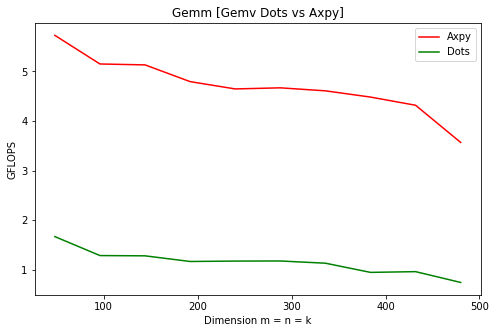

In [23]:
directory = join("..", "data")
filenames = ["output_J_Gemv_J_Axpy", "output_J_Gemv_I_Dots"]
labels = ["Axpy", "Dots"]
colors = ["r", "g"]

fig_size = [8, 5]
fix, ax = plt.subplots(1, figsize=fig_size)
for file, label, color in zip(filenames, labels, colors):
    data = get_matlab_data(directory, file)
    if np.any(data[:, 5] > 1e-10):
        raise Exception("Hmmm, better check if there is an accuracy problem")
    ax.plot(data[:, 0], data[:, 4], color=color, label=label)
ax.set_title("Gemm [Gemv Dots vs Axpy]")
ax.set_xlabel("Dimension m = n = k")
ax.set_ylabel("GFLOPS")
ax.legend(loc="upper right")
plt.show()

From this plot, we can conclude that the **Axpy** approach gives
better performance than that of **Dot product** by approximately
four times.